In [1]:
import os
import os.path
#abspath = os.path.abspath(__file__)
#dname = os.path.dirname(abspath)
#os.chdir(dname)
import rrsBdtDevDependencies
import dataFunctions as dataFun
from datetime import datetime as dt

In [2]:
### CONFIGURE ###
barrels = 750000
costPerDay = 30000
days = 1
trainDataDate = '2018-01-01'

In [3]:
print('Running...')

def show_more(df, lines):
    with pd.option_context("display.max_rows", lines):
        display(df)

Running...


In [4]:
import quandl
wtiData = quandl.get("FRED/DCOILWTICO")

In [5]:
wtiData.reset_index(level=0, inplace=True)
wtiData = wtiData.rename(columns={"Value": "Prices"})
wtiData.head()

,Date,Prices
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


In [6]:
import yfinance as yf

yfStartDate = wtiData['Date'].iloc[-1].strftime('%Y-%m-%d')
stocks = "CL=F"
period = "1d"
Stocks, yfInfo = dataFun.yFinData(yfStartDate)

wtiData = wtiData.append(Stocks, ignore_index =True)
wtiData = wtiData.sort_values(by = ["Date"])

[*********************100%***********************]  1 of 1 completed


In [7]:
import numpy as np
oilDF = dataFun.oilProduction()

df = dataFun.combineFrames(wtiData,oilDF)
df = df[np.isfinite(df['Prices'])]
df = df.reset_index().drop(["index"], axis = 1)
df

,Date,Prices,Production of Crude Oil
0,1986-01-03,26.000000,8942.0
1,1986-01-06,26.530000,8942.0
2,1986-01-07,25.850000,8942.0
3,1986-01-08,25.870000,8942.0
4,1986-01-09,26.030000,8942.0
5,1986-01-10,25.650000,8942.0
6,1986-01-13,25.080000,8942.0
7,1986-01-14,24.970000,8942.0
8,1986-01-15,25.180000,8942.0
9,1986-01-16,23.980000,8942.0


In [8]:
natGasData = quandl.get("EIA/NG_RNGWHHD_D")
natGasData.reset_index(level=0, inplace=True)
natGasData = natGasData.rename(columns={"Value": "NatGasPrices"})

yfStartDate = natGasData['Date'].iloc[-1].strftime('%Y-%m-%d')
stocks = "NG=F"
period = "1d"
NGStocks, yfInfo = dataFun.yFinData(yfStartDate,stock=stocks,name ="NatGasPrices")
natGasData = natGasData.append(NGStocks, ignore_index =True)
natGasData = natGasData.sort_values(by = ["Date"])
natGasData

[*********************100%***********************]  1 of 1 completed


,Date,NatGasPrices
0,1997-01-07,3.820
1,1997-01-08,3.800
2,1997-01-09,3.610
3,1997-01-10,3.920
4,1997-01-13,4.000
5,1997-01-14,4.010
6,1997-01-15,4.340
7,1997-01-16,4.710
8,1997-01-17,3.910
9,1997-01-20,3.260


In [9]:
import pandas as pd
newdf = pd.merge(df, natGasData, on=['Date'], how ="left")
newdf.head()

,Date,Prices,Production of Crude Oil,NatGasPrices
0,1986-01-03,26.00,8942.0,NaN
1,1986-01-06,26.53,8942.0,NaN
2,1986-01-07,25.85,8942.0,NaN
3,1986-01-08,25.87,8942.0,NaN
4,1986-01-09,26.03,8942.0,NaN


In [10]:
brentData = quandl.get("FRED/DCOILBRENTEU")
brentData.reset_index(level=0, inplace=True)
name = "BrentPrices"
brentData = brentData.rename(columns={"Value": name})

yfStartDate = brentData['Date'].iloc[-1].strftime('%Y-%m-%d')
stocks = "BZ=F"
period = "1d"
BStocks, yfInfo = dataFun.yFinData(yfStartDate,stock=stocks,name = name)
brentData = brentData.append(BStocks, ignore_index =True)
brentData = brentData.sort_values(by = ["Date"])
brentData

[*********************100%***********************]  1 of 1 completed


,Date,BrentPrices
0,1987-05-20,18.630000
1,1987-05-21,18.450000
2,1987-05-22,18.550000
3,1987-05-25,18.600000
4,1987-05-26,18.630000
5,1987-05-27,18.600000
6,1987-05-28,18.600000
7,1987-05-29,18.580000
8,1987-06-01,18.650000
9,1987-06-02,18.680000


In [11]:
df = pd.merge(newdf, brentData, on=['Date'], how ="left")
df = df[df["Date"] > trainDataDate]
df = df.rename(columns={"Production of Crude Oil": "OilProduction"})
df.isna().sum()


Date             0
Prices           0
OilProduction    0
NatGasPrices     4
BrentPrices      5
dtype: int64

In [12]:
df["BrentPrices"] = df["BrentPrices"].interpolate(method='nearest')
df["NatGasPrices"] = df["NatGasPrices"].interpolate(method='nearest')
df.isna().sum()

Date             0
Prices           0
OilProduction    0
NatGasPrices     0
BrentPrices      1
dtype: int64

In [13]:
df = df.reset_index().drop(["index"], axis = 1)
df["20dSMA"] = dataFun.SMA(20, df["Prices"])
df["10dSMA"] = dataFun.SMA(10, df["Prices"])
df["5dSMA"] = dataFun.SMA(5, df["Prices"])
df["50dSMA"] = dataFun.SMA(50, df["Prices"])
df["200dSMA"] = dataFun.SMA(200, df["Prices"])


df["boll_lo"] = dataFun.bollinger(df['Prices'])[0]
df["boll_hi"] = dataFun.bollinger(df['Prices'])[1]

df = dataFun.momentum(df, 14)
df = dataFun.macd(df, 12, 26)
df = dataFun.rate_of_change(df, 14)
df = dataFun.relative_strength_index(df)

df["boll_hi"] = pd.to_numeric(df["boll_hi"])
df["boll_lo"] = pd.to_numeric(df["boll_lo"])
df["20dSMA"] = pd.to_numeric(df["20dSMA"])
df["10dSMA"] = pd.to_numeric(df["10dSMA"])
df["5dSMA"] = pd.to_numeric(df["5dSMA"])
df["50dSMA"] = pd.to_numeric(df["50dSMA"])
df["200dSMA"] = pd.to_numeric(df["200dSMA"])

df["bollAmplitude"] = df["boll_hi"] - df["boll_lo"]
df["distFromTopBoll"] = df["boll_hi"] - df["Prices"]
df["distFromLowBoll"] = df["boll_lo"] - df["Prices"]
df["20d200dDist"] = np.abs(df["20dSMA"] - df["200dSMA"])
df

,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,200dSMA,...,Momentum_14,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,ROC_14,RSI_14,bollAmplitude,distFromTopBoll,distFromLowBoll,20d200dDist
0,2018-01-02,60.370000,9782.0,6.240,66.650000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-03,61.610000,9782.0,6.240,67.850000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-04,61.980000,9782.0,4.650,68.730000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-05,61.490000,9492.0,4.650,68.010000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-08,61.730000,9492.0,2.890,68.480000,NaN,NaN,61.436000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-01-09,62.920000,9492.0,2.930,69.080000,NaN,NaN,61.946000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-01-10,63.600000,9492.0,3.160,69.790000,NaN,NaN,62.344000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-01-11,63.810000,9492.0,3.160,70.360000,NaN,NaN,62.710000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-01-12,64.220000,9750.0,4.060,69.640000,NaN,NaN,63.256000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018-01-16,63.820000,9750.0,5.460,69.400000,NaN,62.555,63.674000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df = df[np.isfinite(df['200dSMA'])]
df.isna().sum()

Date               0
Prices             0
OilProduction      0
NatGasPrices       0
BrentPrices        1
20dSMA             0
10dSMA             0
5dSMA              0
50dSMA             0
200dSMA            0
boll_lo            0
boll_hi            0
Momentum_14        0
MACD_12_26         0
MACDsign_12_26     0
MACDdiff_12_26     0
ROC_14             0
RSI_14             0
bollAmplitude      0
distFromTopBoll    0
distFromLowBoll    0
20d200dDist        0
dtype: int64

In [15]:
df = df.drop_duplicates("Date",keep="first")
df

,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,200dSMA,...,Momentum_14,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,ROC_14,RSI_14,bollAmplitude,distFromTopBoll,distFromLowBoll,20d200dDist
199,2018-10-16,71.930000,10900.0,3.270,80.530000,73.0510,73.365,71.866000,70.1724,67.33960,...,-0.290000,0.544398,0.990059,-0.445661,-0.003464,4.112887,6.809132,4.525566,-2.283566,5.71140
200,2018-10-17,69.630000,10900.0,3.300,79.910000,72.9785,72.688,71.156000,70.1816,67.38590,...,-2.550000,0.260303,0.844108,-0.583805,-0.048250,1.756679,7.270465,6.983733,-0.286733,5.59260
201,2018-10-18,68.630000,10900.0,3.280,80.300000,72.8715,72.107,70.688000,70.2158,67.42100,...,-4.530000,-0.045017,0.666283,-0.711300,-0.089426,1.548427,8.030146,8.256573,0.226427,5.45050
202,2018-10-19,69.160000,10900.0,3.200,80.380000,72.7895,71.597,70.238000,70.2628,67.45690,...,-6.210000,-0.241436,0.484739,-0.726175,-0.079830,1.861776,8.506270,7.882635,-0.623635,5.33260
203,2018-10-22,69.250000,10900.0,3.200,80.450000,72.5905,71.095,69.720000,70.2956,67.49570,...,-5.910000,-0.385395,0.310712,-0.696107,-0.093586,1.938645,9.059592,7.870296,-1.189296,5.09480
204,2018-10-23,66.490000,10900.0,3.280,78.670000,72.2450,70.249,68.632000,70.2804,67.51950,...,-9.910000,-0.713962,0.105777,-0.819739,-0.106797,1.381414,10.528714,11.019357,0.490643,4.72550
205,2018-10-24,66.560000,10900.0,3.420,77.340000,71.9620,69.587,68.018000,70.2708,67.53770,...,-7.880000,-0.957666,-0.106911,-0.850754,-0.103690,1.405838,11.692759,11.248379,-0.444379,4.42430
206,2018-10-25,67.250000,10900.0,3.420,77.300000,71.7155,69.215,67.742000,70.3144,67.55595,...,-7.010000,-1.082645,-0.302058,-0.780587,-0.094520,1.759685,12.423946,10.677473,-1.746473,4.15955
207,2018-10-26,67.580000,11200.0,3.270,77.400000,71.4365,68.832,67.426000,70.3572,67.57480,...,-6.690000,-1.141901,-0.470027,-0.671875,-0.098332,2.043524,12.871997,10.292498,-2.579498,3.86170
208,2018-10-29,67.000000,11200.0,3.200,77.560000,71.0180,68.348,66.976000,70.3786,67.58870,...,-7.950000,-1.221582,-0.620338,-0.601244,-0.084449,1.786311,12.895111,10.465556,-2.429556,3.42930


In [16]:
df = df[df["Date"] > trainDataDate]
df = df.reset_index().drop(["index"], axis = 1)
df

,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,200dSMA,...,Momentum_14,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,ROC_14,RSI_14,bollAmplitude,distFromTopBoll,distFromLowBoll,20d200dDist
0,2018-10-16,71.930000,10900.0,3.270,80.530000,73.0510,73.365,71.866000,70.1724,67.33960,...,-0.290000,0.544398,0.990059,-0.445661,-0.003464,4.112887,6.809132,4.525566,-2.283566,5.71140
1,2018-10-17,69.630000,10900.0,3.300,79.910000,72.9785,72.688,71.156000,70.1816,67.38590,...,-2.550000,0.260303,0.844108,-0.583805,-0.048250,1.756679,7.270465,6.983733,-0.286733,5.59260
2,2018-10-18,68.630000,10900.0,3.280,80.300000,72.8715,72.107,70.688000,70.2158,67.42100,...,-4.530000,-0.045017,0.666283,-0.711300,-0.089426,1.548427,8.030146,8.256573,0.226427,5.45050
3,2018-10-19,69.160000,10900.0,3.200,80.380000,72.7895,71.597,70.238000,70.2628,67.45690,...,-6.210000,-0.241436,0.484739,-0.726175,-0.079830,1.861776,8.506270,7.882635,-0.623635,5.33260
4,2018-10-22,69.250000,10900.0,3.200,80.450000,72.5905,71.095,69.720000,70.2956,67.49570,...,-5.910000,-0.385395,0.310712,-0.696107,-0.093586,1.938645,9.059592,7.870296,-1.189296,5.09480
5,2018-10-23,66.490000,10900.0,3.280,78.670000,72.2450,70.249,68.632000,70.2804,67.51950,...,-9.910000,-0.713962,0.105777,-0.819739,-0.106797,1.381414,10.528714,11.019357,0.490643,4.72550
6,2018-10-24,66.560000,10900.0,3.420,77.340000,71.9620,69.587,68.018000,70.2708,67.53770,...,-7.880000,-0.957666,-0.106911,-0.850754,-0.103690,1.405838,11.692759,11.248379,-0.444379,4.42430
7,2018-10-25,67.250000,10900.0,3.420,77.300000,71.7155,69.215,67.742000,70.3144,67.55595,...,-7.010000,-1.082645,-0.302058,-0.780587,-0.094520,1.759685,12.423946,10.677473,-1.746473,4.15955
8,2018-10-26,67.580000,11200.0,3.270,77.400000,71.4365,68.832,67.426000,70.3572,67.57480,...,-6.690000,-1.141901,-0.470027,-0.671875,-0.098332,2.043524,12.871997,10.292498,-2.579498,3.86170
9,2018-10-29,67.000000,11200.0,3.200,77.560000,71.0180,68.348,66.976000,70.3786,67.58870,...,-7.950000,-1.221582,-0.620338,-0.601244,-0.084449,1.786311,12.895111,10.465556,-2.429556,3.42930


In [17]:
def create_features(df, label=None, shift = 0):
    """
    Creates time series features from datetime index
    """
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    df = df.set_index('Date')
    #X = df[['OilProduction', 'NatGasPrices', 'BrentPrices', '20dSMA', 'Momentum_14', 'MACD_12_26', 'MACDdiff_12_26', 'ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist','dayofyear','dayofmonth','weekofyear']]

    X = df[['OilProduction', '20dSMA', 'Momentum_14', 'MACD_12_26', 'MACDdiff_12_26', 'ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist','dayofyear','dayofmonth','weekofyear']]
    if shift > 0:
        tiems = X[['dayofyear','dayofmonth','weekofyear']]
        #X = X[['OilProduction', 'NatGasPrices', 'BrentPrices', '20dSMA', 'Momentum_14', 'MACD_12_26', 'MACDdiff_12_26','ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist']].shift(shift)
        X = X[['OilProduction', '20dSMA', 'Momentum_14', 'MACD_12_26', 'MACDdiff_12_26','ROC_14', 'RSI_14', 'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist']].shift(shift)
        X = X.merge(tiems, how='inner', left_index=True, right_index=True)

    if label:
        y = df[label]
        return X, y
    return X

In [18]:
testSplitDate = '2020-01-01'
df_train = df[df["Date"] <= testSplitDate].copy()
df_test = df[df["Date"] > testSplitDate].copy()

X_train, y_train = create_features(df_train, label='Prices', shift =1)
X_test, y_test = create_features(df_test, label='Prices', shift =1)
X_train = X_train.iloc[1:]
X_test = X_test.iloc[1:]
y_train = y_train.iloc[1:]
y_test = y_test.iloc[1:]

In [19]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
plt.style.use('fivethirtyeight')

model = XGBRegressor(
    n_estimators=1000,
    #max_depth=8,
    #min_child_weight=300, 
    #colsample_bytree=0.8, 
    #subsample=0.8, 
    #eta=0.3,    
    #seed=42
    )

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=False, 
    early_stopping_rounds = 100)

[13:17:36] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
//anaconda3/envs/mlcourse/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/envs/mlcourse/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [20]:
model.feature_importances_

array([0.01403122, 0.22543284, 0.07525312, 0.2149428 , 0.01130448,
       0.07619022, 0.01375135, 0.01320271, 0.1045377 , 0.03498582,
       0.16226102, 0.03658603, 0.01103954, 0.00648113], dtype=float32)

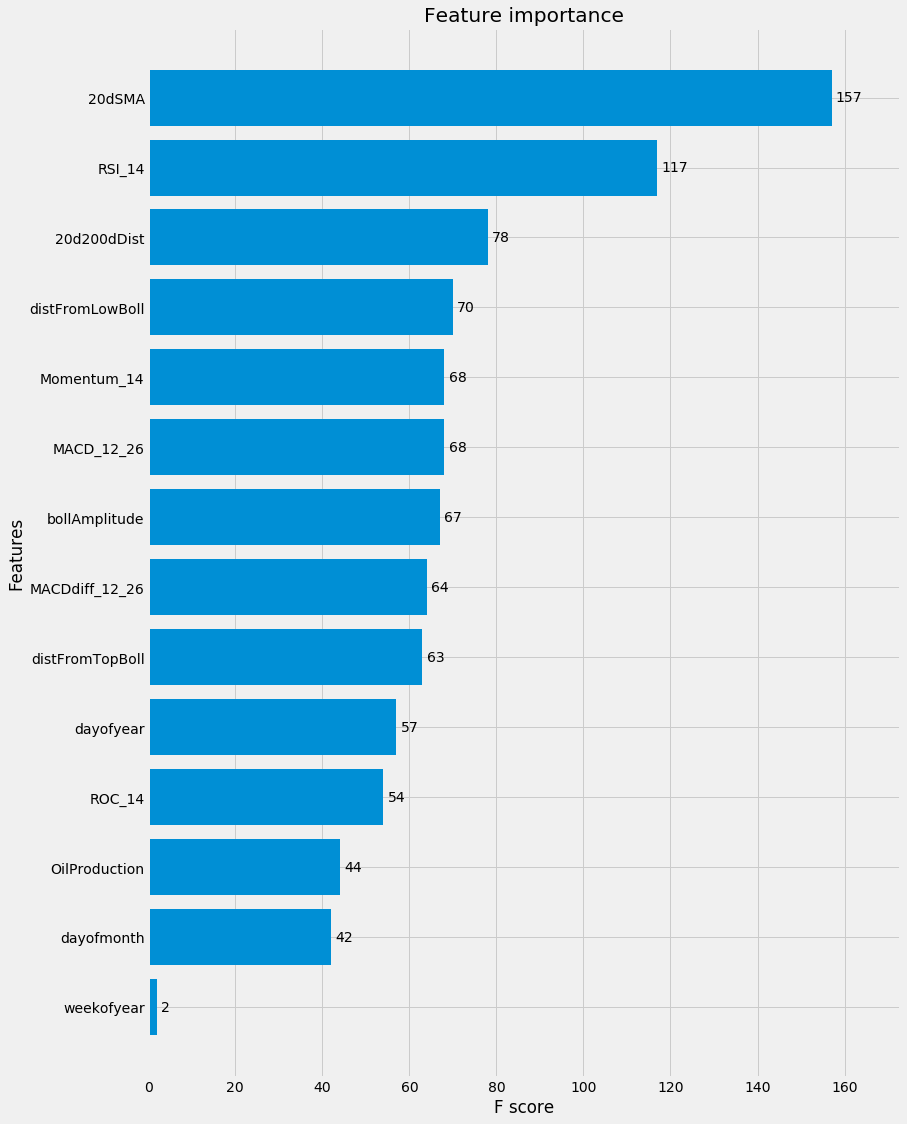

In [21]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

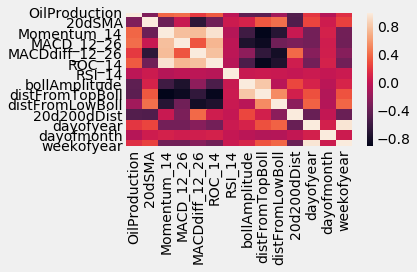

In [22]:
correl = X_train.corr()
sns.heatmap(correl, xticklabels=correl.columns, yticklabels=correl.columns)
plt.tight_layout()
plt.show()

In [23]:
correl

,OilProduction,20dSMA,Momentum_14,MACD_12_26,MACDdiff_12_26,ROC_14,RSI_14,bollAmplitude,distFromTopBoll,distFromLowBoll,20d200dDist,dayofyear,dayofmonth,weekofyear
OilProduction,1.000000,-0.298547,0.386592,0.411441,0.209148,0.339549,-0.029756,-0.446837,-0.462021,-0.149613,-0.498769,0.195944,-0.057089,0.160674
20dSMA,-0.298547,1.000000,-0.385004,0.026007,-0.689933,-0.365744,0.045778,0.098955,0.327969,0.423143,-0.516469,0.255421,0.052377,0.243439
Momentum_14,0.386592,-0.385004,1.000000,0.779846,0.764956,0.952221,-0.058742,-0.593858,-0.914353,-0.717895,0.031996,-0.346733,0.090280,-0.359014
MACD_12_26,0.411441,0.026007,0.779846,1.000000,0.316263,0.737421,-0.023926,-0.760792,-0.850336,-0.364815,-0.315276,-0.349188,0.059858,-0.368027
MACDdiff_12_26,0.209148,-0.689933,0.764956,0.316263,1.000000,0.785926,-0.026208,-0.229362,-0.662487,-0.811928,0.401691,-0.263002,0.069917,-0.266099
ROC_14,0.339549,-0.365744,0.952221,0.737421,0.785926,1.000000,-0.047562,-0.534280,-0.883176,-0.750534,0.059065,-0.347053,0.088951,-0.358332
RSI_14,-0.029756,0.045778,-0.058742,-0.023926,-0.026208,-0.047562,1.000000,0.024883,0.039955,0.032920,0.008023,0.041514,0.010491,0.040812
bollAmplitude,-0.446837,0.098955,-0.593858,-0.760792,-0.229362,-0.534280,0.024883,1.000000,0.815988,-0.041949,0.263585,0.100669,-0.039264,0.108925
distFromTopBoll,-0.462021,0.327969,-0.914353,-0.850336,-0.662487,-0.883176,0.039955,0.815988,1.000000,0.543330,0.077794,0.298182,-0.072063,0.311477
distFromLowBoll,-0.149613,0.423143,-0.717895,-0.364815,-0.811928,-0.750534,0.032920,-0.041949,0.543330,1.000000,-0.248343,0.369170,-0.067529,0.380159


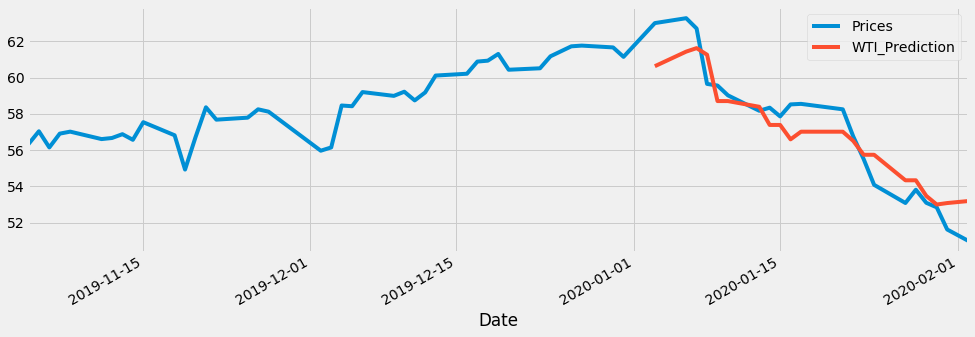

In [24]:
df_test = df_test.iloc[1:]
df_train = df_train.iloc[1:]
df_test['WTI_Prediction'] = model.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)
df_all = df_all.set_index("Date")
_ = df_all[df_all.index > '2019-11-01'][['Prices','WTI_Prediction']].plot(figsize=(15, 5))

In [25]:
X_new = df[df["Date"]>'2020-01-21'].copy()
X_new = create_features(X_new)
X_new


,OilProduction,20dSMA,Momentum_14,MACD_12_26,MACDdiff_12_26,ROC_14,RSI_14,bollAmplitude,distFromTopBoll,distFromLowBoll,20d200dDist,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,,
2020-01-22,13000.0,60.1390,-4.380000,-0.473583,-0.504282,-0.072094,1.456460,7.651305,7.204652,-0.446652,2.39100,22,22,4
2020-01-23,13000.0,59.8890,-5.660000,-0.703798,-0.587597,-0.118889,1.292891,8.684369,8.721184,0.036816,2.17405,23,23,4
2020-01-24,13000.0,59.5350,-8.910000,-0.989421,-0.698576,-0.145092,1.199286,10.012216,10.451108,0.438892,1.86510,24,24,4
2020-01-27,13000.0,59.1035,-10.180000,-1.281697,-0.792682,-0.153270,1.158202,11.316695,11.671847,0.355153,1.49000,27,27,5
2020-01-28,13000.0,57.4595,-5.200000,-1.759251,-0.559712,-0.074781,1.649007,13.465974,10.372487,-3.093486,0.06245,28,28,5
2020-01-29,13000.0,56.9645,-5.070002,-1.793364,-0.475060,-0.089818,1.456962,12.936766,10.332884,-2.603881,0.38090,29,29,5
2020-01-30,13000.0,56.4435,-5.490002,-1.819597,-0.401034,-0.086588,1.408530,11.981771,9.584387,-2.397384,0.84610,30,30,5
2020-01-31,13000.0,55.8900,-6.229999,-1.916735,-0.398537,-0.117738,1.255845,11.178159,9.849078,-1.329081,1.33905,31,31,5
2020-02-02,13000.0,55.4580,-7.510002,-2.020456,-0.401807,-0.128779,1.209854,11.399868,10.147936,-1.251932,1.70600,33,2,5


In [26]:
new_pred = model.predict(X_new)
new_pred

array([55.745552, 55.745552, 54.481216, 54.33953 , 53.479477, 53.005074,
       53.085945, 53.03896 , 52.9472  ], dtype=float32)

In [27]:
df["Prices"].iloc[-1]

51.0099983215332

In [28]:
new_pred > df["Prices"].iloc[-1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

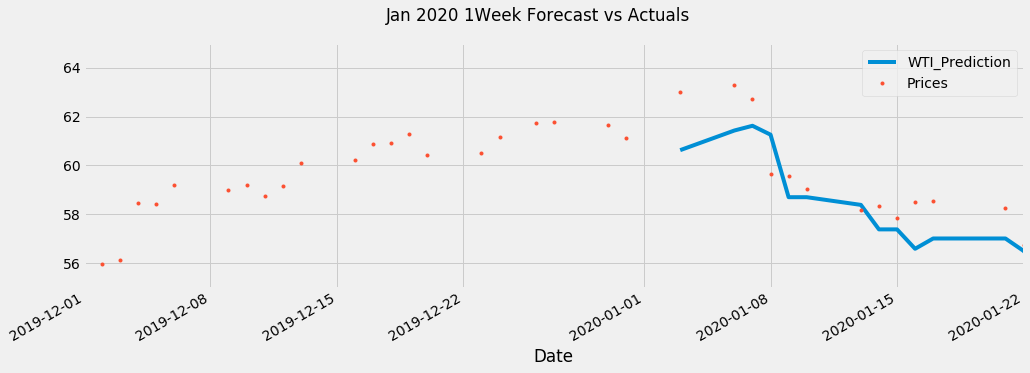

In [29]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['WTI_Prediction','Prices']].plot(ax=ax,style=['-','.'])
ax.set_xbound(lower='2019-12-01', upper='2020-01-22')
ax.set_ylim(55, 65)
plot = plt.suptitle('Jan 2020 1Week Forecast vs Actuals')

In [30]:
mean_squared_error(y_true=df_test['Prices'],
                   y_pred=df_test['WTI_Prediction'])

1.6243922175239878

In [31]:
testSplitDate = '2020-01-21'
fin_df_train = df[df["Date"] <= testSplitDate].copy()
fin_df_test = df[df["Date"] > testSplitDate].copy()

X_train, y_train = create_features(fin_df_train, label='Prices')
X_test, y_test = create_features(fin_df_test, label='Prices')

model = XGBRegressor(
    n_estimators=1000,
    #max_depth=8,
    #min_child_weight=300, 
    #colsample_bytree=0.8, 
    #subsample=0.8, 
    #eta=0.3,    
    #seed=42
    )

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=False, 
    early_stopping_rounds = 100)

[13:17:38] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
//anaconda3/envs/mlcourse/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/envs/mlcourse/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [32]:
from sklearn.externals import joblib

modDate = str(fin_df_train["Date"].iloc[-1].strftime('%Y-%m-%d'))
filename = 'finalized_model_'+modDate+'.sav'
joblib.dump(model, filename)

//anaconda3/envs/mlcourse/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['finalized_model_2020-01-21.sav']

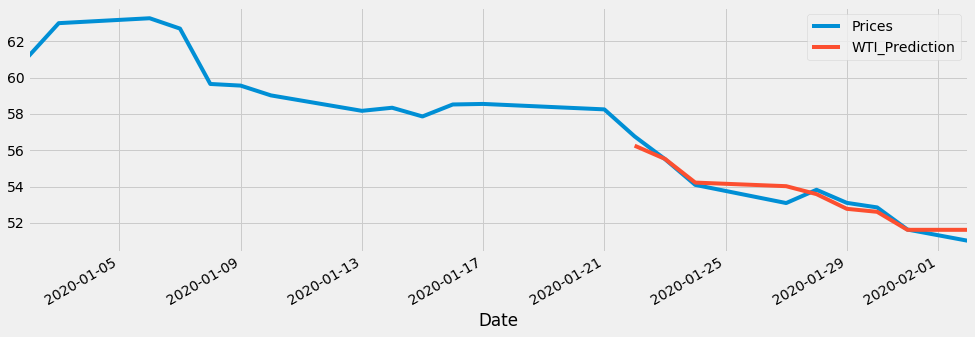

In [33]:
fin_df_test['WTI_Prediction'] = model.predict(X_test)
fin_df_all = pd.concat([fin_df_test, fin_df_train], sort=False)
fin_df_all = fin_df_all.set_index("Date")
_ = fin_df_all[fin_df_all.index > '2020-01-01'][['Prices','WTI_Prediction']].plot(figsize=(15, 5))

In [34]:
fin_df_test

,Date,Prices,OilProduction,NatGasPrices,BrentPrices,20dSMA,10dSMA,5dSMA,50dSMA,200dSMA,...,distFromLowBoll,20d200dDist,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,WTI_Prediction
313,2020-01-22,56.760000,13000.0,1.890,62.110000,60.1390,58.468,57.988000,58.9566,57.74800,...,-0.446652,2.39100,2,1,1,2020,22,22,4,56.249798
314,2020-01-23,55.510000,13000.0,1.950,61.260000,59.8890,58.054,57.518000,58.9286,57.71495,...,0.036816,2.17405,3,1,1,2020,23,23,4,55.522369
315,2020-01-24,54.090000,13000.0,1.910,59.340000,59.5350,57.507,56.632000,58.8700,57.66990,...,0.438892,1.86510,4,1,1,2020,24,24,4,54.216564
316,2020-01-27,53.090000,13000.0,2.030,58.540000,59.1035,56.914,55.540000,58.7996,57.61350,...,0.355153,1.49000,0,1,1,2020,27,27,5,54.018452
317,2020-01-28,53.820000,13000.0,1.960,59.720001,57.4595,54.910,53.188000,58.5034,57.39705,...,-3.093486,0.06245,1,1,1,2020,28,28,5,53.581032
318,2020-01-29,53.099998,13000.0,1.960,59.599998,56.9645,54.365,53.190000,58.4290,57.34540,...,-2.603881,0.38090,2,1,1,2020,29,29,5,52.771400
319,2020-01-30,52.849998,13000.0,1.960,59.070000,56.4435,53.825,53.142000,58.3874,57.28960,...,-2.397384,0.84610,3,1,1,2020,30,30,5,52.607014
320,2020-01-31,51.630001,13000.0,1.858,58.150002,55.8900,53.312,52.874000,58.2858,57.22905,...,-1.329081,1.33905,4,1,1,2020,31,31,5,51.614658
321,2020-02-02,51.009998,13000.0,1.858,NaN,55.4580,52.862,52.481999,58.1388,57.16400,...,-1.251932,1.70600,6,1,2,2020,33,2,5,51.614658


In [35]:
fin_df_all[fin_df_all.index > '2020-01-22'][['Prices','WTI_Prediction']]

,Prices,WTI_Prediction
Date,,
2020-01-23,55.510000,55.522369
2020-01-24,54.090000,54.216564
2020-01-27,53.090000,54.018452
2020-01-28,53.820000,53.581032
2020-01-29,53.099998,52.771400
2020-01-30,52.849998,52.607014
2020-01-31,51.630001,51.614658
2020-02-02,51.009998,51.614658


In [36]:
#Chris Wright's modifications

In [37]:
comparison_df = fin_df_all[fin_df_all.index > '2020-01-22'][['Prices','WTI_Prediction']]

WTI_Objective = pd.Series(np.zeros(len(comparison_df.index)))

Truth_Objective = pd.Series(np.zeros(len(comparison_df.index)))

comparison_df['Truth_Objective'] = Truth_Objective
comparison_df['WTI_Objective'] = WTI_Objective

comparison_df['Truth_Objective'][0] = -1
comparison_df['WTI_Objective'][0] = -1


for i in range(1,len(comparison_df.index)):
    Delta = comparison_df['WTI_Prediction'][i]-comparison_df['WTI_Prediction'][i-1]

    if Delta > 0:
        comparison_df['WTI_Objective'][i] = 1
        
    else:
        comparison_df['WTI_Objective'][i] = -1
    
    Delta = comparison_df['Prices'][i]-comparison_df['Prices'][i-1]

    if Delta > 0:
        comparison_df['Truth_Objective'][i] = 1
    else:
        comparison_df['Truth_Objective'][i] = -1

    comparison_df['Truth_Objective'][0] = Truth_Objective[0]
    
    comparison_df['WTI_Objective'][0] = WTI_Objective[0]

print(Truth_Objective)
print(WTI_Objective)
print(comparison_df)

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
dtype: float64
               Prices  WTI_Prediction  Truth_Objective  WTI_Objective
Date                                                                 
2020-01-23  55.510000       55.522369              0.0            0.0
2020-01-24  54.090000       54.216564             -1.0           -1.0
2020-01-27  53.090000       54.018452             -1.0           -1.0
2020-01-28  53.820000       53.581032              1.0           -1.0
2020-01-29  53.099998       52.771400             -1.0           -1.0
2020-01-30  52.849998       52.607014             -1.0           -1.0
2020-01-31  51.630001       51.614658             -1.0           -1.0
2020-02-02  51.009998       51.614658             -1.0           -1.0
//anaconda3/envs/mlcourse/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to 

In [38]:
for i in range(10,len(df.index)):
    print(i)
    df_iter = df[0:][0:i+1]
    arr = np.zeros(i)

    testSplitDate = df_iter.Date[i-1].strftime("%Y-%m-%d")
    
    iterative_df_train = df_iter[df_iter["Date"] <= testSplitDate].copy()
    iterative_df_test = df_iter[df_iter["Date"] > testSplitDate].copy()

    X_train, y_train = create_features(iterative_df_train, label='Prices')
    X_test, y_test = create_features(iterative_df_test, label='Prices')
    
    model = XGBRegressor(
        n_estimators=1000,
        #max_depth=8,
        #min_child_weight=300, 
        #colsample_bytree=0.8, 
        #subsample=0.8, 
        #eta=0.3,    
        #seed=42
        )

    model.fit(
        X_train, 
        y_train, 
        eval_metric="rmse", 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        verbose=False, 
        early_stopping_rounds = 100
    )
    
    df_iter['WTI_Prediction'] = model.predict(X_test)
    df_iter['WTI_Prediction'][i] = model.predict(X_test)[i]

10
[13:17:39] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


ValueError: Length of values does not match length of index